In [190]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.hsv(np.linspace(0, 1, 256)) * 0.85, N=256
)
# colors = ["#95D3A2", "#FFFFBF", "#F79051", ]
colors = ["#5657A4", "#95D3A2", "#FFFFBF", "#F79051", "#A30644"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from main import *
from multiprocessing import Pool
import pandas as pd

SAVE_PATH = r"E:\MS_ExperimentData\general"
# SAVE_PATH = r"D:\MS_ExperimentData\general"

In [174]:
pathShift = 20
center = 100
patternHalfLength = 20
nodePosition = [
    [
        [center - pathShift * i, center - pathShift * i],
        [center - pathShift * i, center + pathShift * i],
        [center + pathShift * i, center - pathShift * i],
        # [center + pathShift * i, center + pathShift * i]
    ]
    # for i in range(0, patternHalfLength // pathShift + 1)
    for i in range(1, patternHalfLength // pathShift + 1)
]
nodePosition = np.unique(np.concatenate(nodePosition, axis=0), axis=0)
# nodePosition

In [222]:
class PathPlanningGSC(PatternFormation):
    def __init__(self, 
                 nodePosition: np.ndarray, 
                 productRateBetac: float,
                 cUpperThres: float = 3, cDecayBase: float = 0.8, cControlThres: float = 0.5,
                 boundaryLength: float = 100, noiseRateBetaDp: float = 0.1,
                 decayRateKc: float = 1,
                 diameter: float = 0.1, 
                 repelPower: float = 1, repCutOff: bool = True,
                 chemoAlphaC: float = 1,
                 diffusionRateDc: float = 1,
                 cellNumInLine: int = 100, 
                 agentsNum: int=1000, dt: float=0.01, 
                 tqdm: bool = False, savePath: str = None, shotsnaps: int = 10, 
                 randomSeed: int = 10, overWrite: bool = False) -> None:

        self.halfAgentsNum = agentsNum // 2

        np.random.seed(randomSeed)
        self.nodePosition = nodePosition
        self.positionX = np.random.random((agentsNum, 2)) * boundaryLength
        self.internalState = np.ones(agentsNum) * 0.5
        self.cellNumInLine = cellNumInLine
        self.cPosition = np.array(list(product(np.linspace(0, boundaryLength, cellNumInLine), repeat=2)))
        self.dx = boundaryLength / (cellNumInLine - 1)
        self.agentsNum = agentsNum
        self.decayRateKc = decayRateKc
        self.diffusionRateDc = diffusionRateDc
        self.dt = dt
        self.diameter = diameter
        self.repelPower = repelPower
        self.repCutOff = repCutOff
        self.cUpperThres = cUpperThres
        self.cDecayBase = cDecayBase
        self.cControlThres = cControlThres

        self.noiseRateBetaDp = noiseRateBetaDp
        self.noiseMultiAdj = np.sqrt(2 * self.noiseRateBetaDp)

        productAdjMulti = boundaryLength**2 / cellNumInLine**2
        self.productRateBetac = productRateBetac * productAdjMulti
        
        self.tqdm = tqdm
        self.savePath = savePath
        self.shotsnaps = shotsnaps
        self.counts = 0
        self.boundaryLength = boundaryLength
        self.halfBoundaryLength = boundaryLength / 2
        self.randomSeed = randomSeed
        self.overWrite = overWrite

        self.c = np.zeros((cellNumInLine, cellNumInLine))
        self.chemoAlphaC = chemoAlphaC

        self.temp = dict()
        # The order of variable definitions has a dependency relationship
        self.temp["ocsiIdx"] = (self.positionX / self.dx).round().astype(int)
        self.temp["nodeIdx"] = (self.nodePosition / self.dx).round().astype(int)
        if len(nodePosition) > 0:
            self.temp["productDeltaNode"] = self.calc_product_delta(idxKey="nodeIdx") 
        else:
            self.temp["productDeltaNode"] = np.zeros((cellNumInLine, cellNumInLine))

    @property
    def nablaC(self):
        return - np.array([ 
            (np.roll(self.c, -1, axis=0) - np.roll(self.c, 1, axis=0)),
            (np.roll(self.c, -1, axis=1) - np.roll(self.c, 1, axis=1))
        ]).transpose(1, 2, 0) / (2 * self.dx)
    
    @staticmethod
    @nb.njit
    def _product_c(cellNumInLine: int, ocsiIdx: np.ndarray, productRateK0: np.ndarray, meaning: bool = False):
        
        productC = np.zeros((cellNumInLine, cellNumInLine), dtype=np.float64)
        counts = np.zeros((cellNumInLine, cellNumInLine), dtype=np.int32)

        for i, idx in enumerate(ocsiIdx):
            productC[idx[0], idx[1]] = productC[idx[0], idx[1]] + productRateK0[i]
            counts[idx[0], idx[1]] = counts[idx[0], idx[1]] + 1
        if meaning:
            counts = np.where(counts == 0, 1, counts)
            productC = productC / counts

        return productC
    
    @property
    def productC(self):
        return self.temp["productDeltaNode"] * self.productRateBetac
    
    @property
    def dotC(self):
        localState = self._product_c(self.cellNumInLine, self.temp["ocsiIdx"], self.internalState, meaning=False)
        return (
            self.diffusionRateDc * self.nabla2C
            - self.decayRateKc * (self.cDecayBase - localState) * self.c
            + self.productC
        ) * (self.cUpperThres - self.c)
    
    @property
    def dotInternalState(self):
        localC = self.c[self.temp["ocsiIdx"][:, 0], self.temp["ocsiIdx"][:, 1]]
        return self.internalState * (1 - self.internalState) * (localC - self.cControlThres)

    @property
    def localGradient(self):
        localGradC = self.nablaC[self.temp["ocsiIdx"][:, 0], self.temp["ocsiIdx"][:, 1]]
        return self.chemoAlphaC * localGradC

    @property
    def spatialNoise(self):
        noise = self.noiseMultiAdj * np.random.normal(
            loc=0, scale=1, size=(self.agentsNum, 2)
        )
        return noise

    @staticmethod
    @nb.njit
    def _short_rep(positionX: np.ndarray, diameter: float,
                   halfBoundaryLength: float, boundaryLength: float, 
                   power: float, cutOff: bool):
        if not cutOff:
            diameter = np.inf
        rep = np.zeros(positionX.shape)
        for i in range(positionX.shape[0]):
            neighborPos: np.ndarray = positionX[
                (np.abs(positionX[:, 0] - positionX[i, 0]) % halfBoundaryLength < diameter)
                & (np.abs(positionX[:, 1] - positionX[i, 1]) % halfBoundaryLength < diameter)
                & ((positionX[:,0] != positionX[i,0]) | (positionX[:, 1] != positionX[i, 1]))
            ]
            if neighborPos.shape[0]== 0:
                continue
            subX = positionX[i] - neighborPos
            deltaX =(
                subX * (-halfBoundaryLength<= subX) * (subX<= halfBoundaryLength) + 
                (subX + boundaryLength) * (subX < -halfBoundaryLength)+
                (subX - boundaryLength) * (subX > halfBoundaryLength)
            )
            distance = np.sqrt(deltaX[:, 0] ** 2 + deltaX[:,1] ** 2).reshape(-1, 1)
            if cutOff:            
                rep[i] = np.sum(deltaX / distance ** power * (distance < diameter), axis=0)
            else:
                rep[i] = np.sum(deltaX / distance ** power, axis=0)

        return rep

    @property
    def shortRepulsion(self):
        return self._short_rep(
            self.positionX, self.diameter,
            self.halfBoundaryLength, self.boundaryLength, 
            self.repelPower, self.repCutOff
        )

    def calc_product_delta(self, idxKey: str):
        if idxKey == "ocsiIdx":
            return self._product_c(self.cellNumInLine, self.temp[idxKey], self.temp["neighborsNum"])
        else:  # nodeIdx
            return self._product_c(self.cellNumInLine, self.temp[idxKey], np.ones(self.agentsNum))

    def update(self):
        self.temp["ocsiIdx"] = (self.positionX / self.dx).round().astype(int)
        shortRepulsion = self.shortRepulsion
        if self.diameter == 0:
            dotPosition = self.localGradient + self.spatialNoise
        else:
            dotPosition = self.localGradient + self.spatialNoise + shortRepulsion
        dotInternalState = self.dotInternalState
        dotC = self.dotC
        
        self.positionX = np.mod(
            self.positionX + dotPosition * self.dt, 
            self.boundaryLength
        )
        self.internalState += dotInternalState * self.dt
        self.c += dotC * self.dt
        self.c[self.c < 0] = 0

    def append(self):
        if self.store is not None:
            if self.counts % self.shotsnaps != 0:
                return
            self.store.append(key="positionX", value=pd.DataFrame(self.positionX))
            self.store.append(key="internalState", value=pd.DataFrame(self.internalState))
            self.store.append(key="c", value=pd.DataFrame(self.c))

    def __str__(self) -> str:
        name =  (
            f"PPGS"
            f"_bC{self.productRateBetac:.3f}"
            f"_cUT{self.cUpperThres:.3f}_cDB{self.cDecayBase:.3f}"
            f"_cCT{self.cControlThres:.3f}"
            f"_d{self.diameter:.1f}_rep{self.repelPower:.1f}"
            f"_cutoff{self.repCutOff}_noise{self.noiseRateBetaDp:.3f}"
            f"_Dc{self.diffusionRateDc:.3f}"
            f"_r{self.randomSeed}_dt{self.dt:.3f}"
        )
        
        return name

In [223]:
model = PathPlanningGSC(
    nodePosition=nodePosition, noiseRateBetaDp=0.1,
    # nodePosition=np.array([]),
    cUpperThres=3, cDecayBase=0.8, cControlThres=0.5,
    productRateBetac=0.3,
    decayRateKc=0.01,
    diffusionRateDc=3,
    chemoAlphaC=-1,
    diameter=3, repelPower=2, repCutOff=True,
    boundaryLength=200, cellNumInLine=70,
    tqdm=True, dt=0.1, savePath=SAVE_PATH, shotsnaps=100
)

model.run(8000)
# model.run(8000)

  0%|          | 0/8000 [00:00<?, ?it/s]

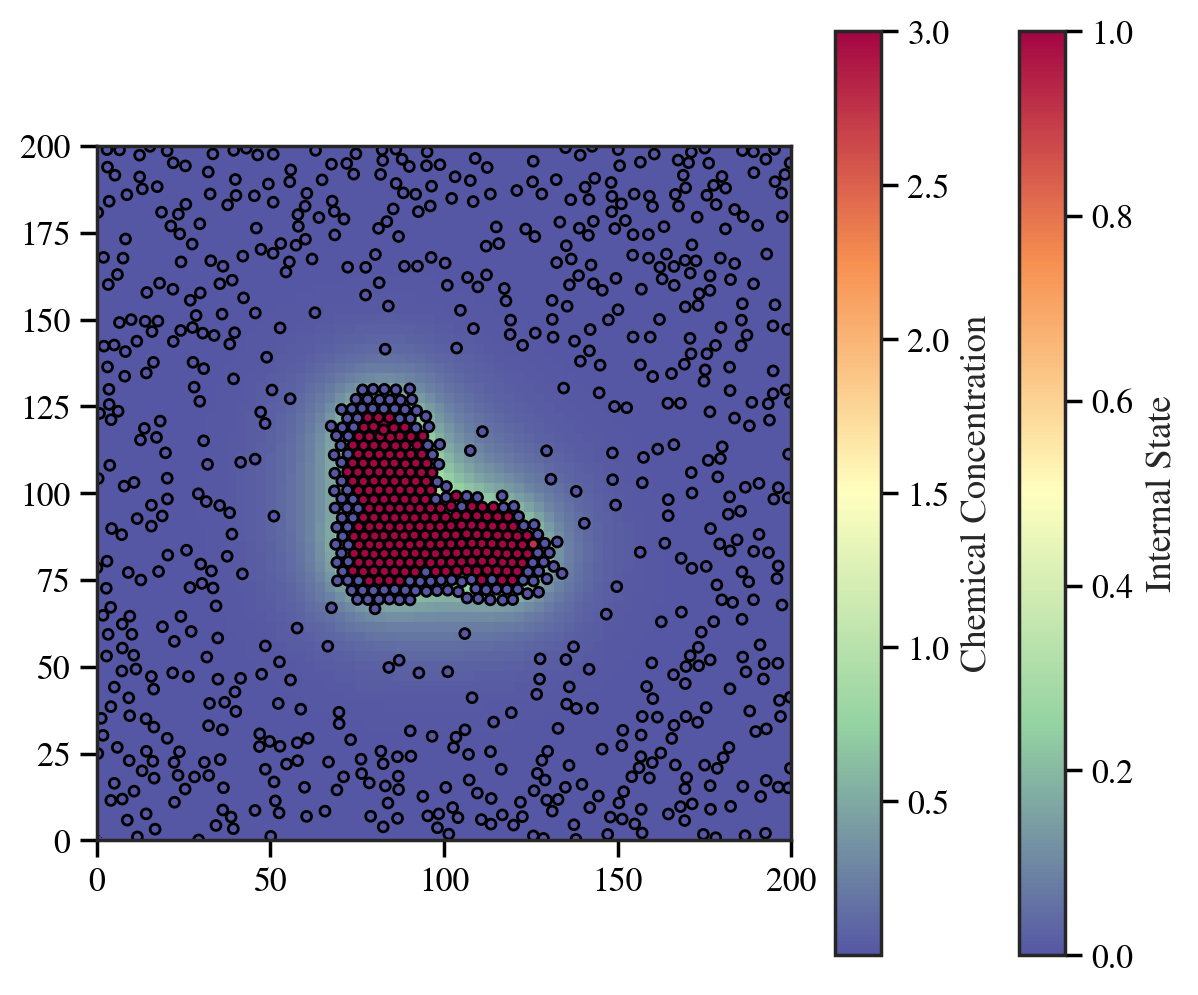

In [192]:
self = model

_, ax = plt.subplots(figsize=(7, 6))

unitInternalState = model.internalState / np.max(model.internalState)
stateColors = cmap(unitInternalState)

for i in range(self.agentsNum):
    ax.add_artist(plt.Circle(
        self.positionX[i], self.diameter / 2 * 0.95, zorder=1, 
        # facecolor="#9BD5D5", edgecolor="black"
        facecolor=stateColors[i], edgecolor="black"
    ))
sc = plt.scatter(np.full_like(self.internalState, -1), np.full_like(self.internalState, -1), 
                 c=model.internalState, cmap=cmap, vmin=0, vmax=np.max(model.internalState))
plt.colorbar(sc, ax=ax, label="Internal State")
ax.set_xlim(0, self.boundaryLength)
ax.set_ylim(0, self.boundaryLength)

im = ax.imshow(model.c.T, cmap=cmap, 
               extent=(0, self.boundaryLength, 0, self.boundaryLength),
               origin="lower", alpha=1, zorder=0)
plt.colorbar(im, ax=ax, label="Chemical Concentration")

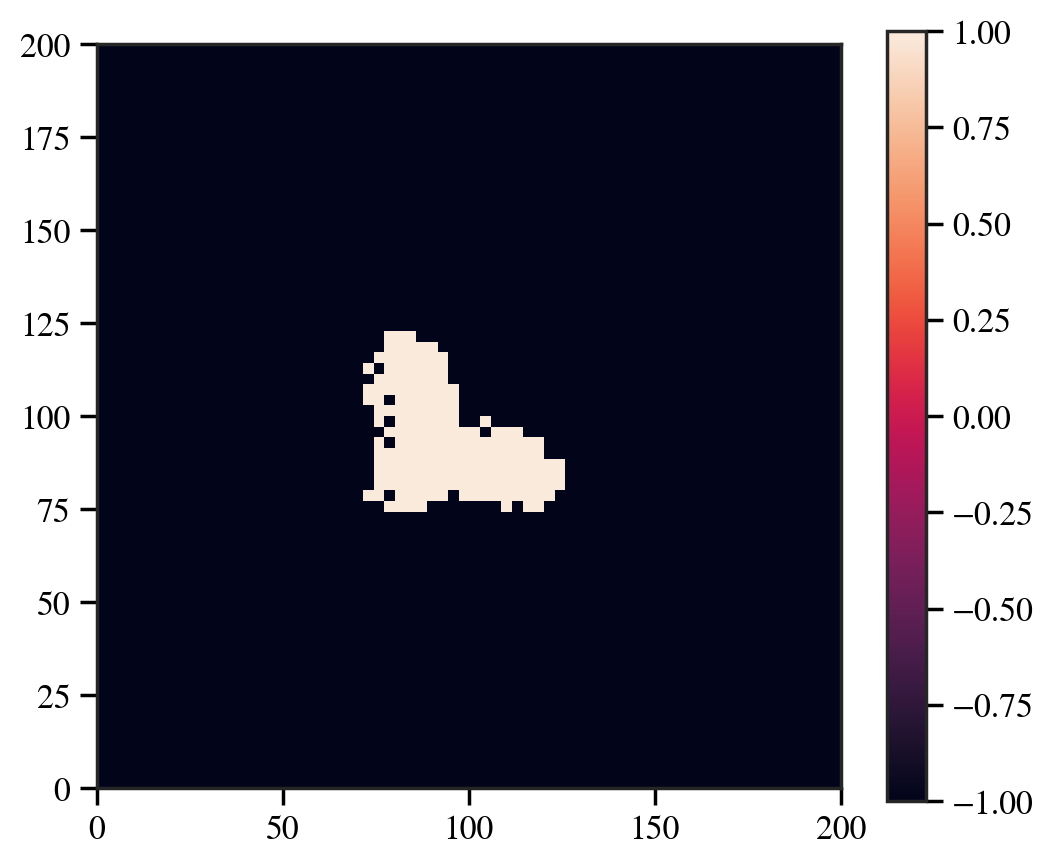

In [198]:
localState = self._product_c(self.cellNumInLine, self.temp["ocsiIdx"], self.internalState, meaning=False)
dotC = np.sign(
    # self.diffusionRateDc * self.nabla2C
    - self.decayRateKc * (0.8 - localState) * self.c
    # + self.productC
)
plt.imshow(dotC.T, extent=(0, self.boundaryLength, 0, self.boundaryLength),
            #    interpolation="bilinear", 
               origin="lower", 
               alpha=1, zorder=0)
plt.colorbar()

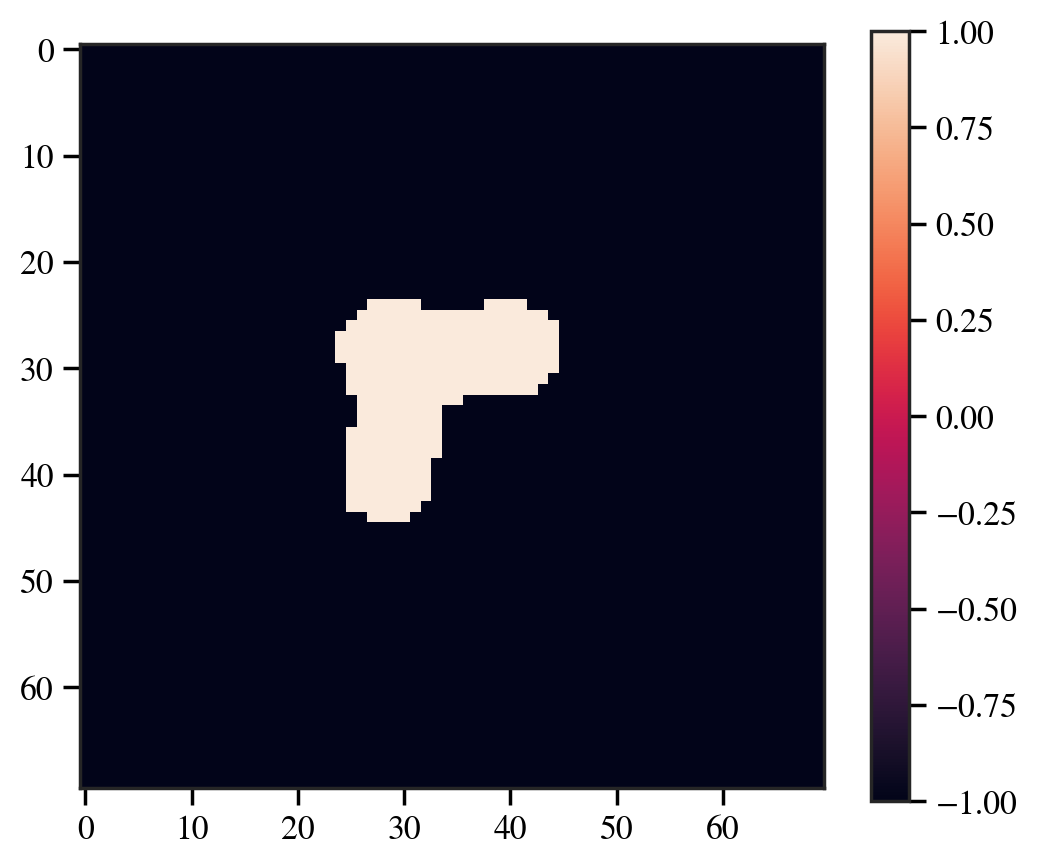

In [180]:
plt.imshow(np.sign(model.c - 0.5))
plt.colorbar()

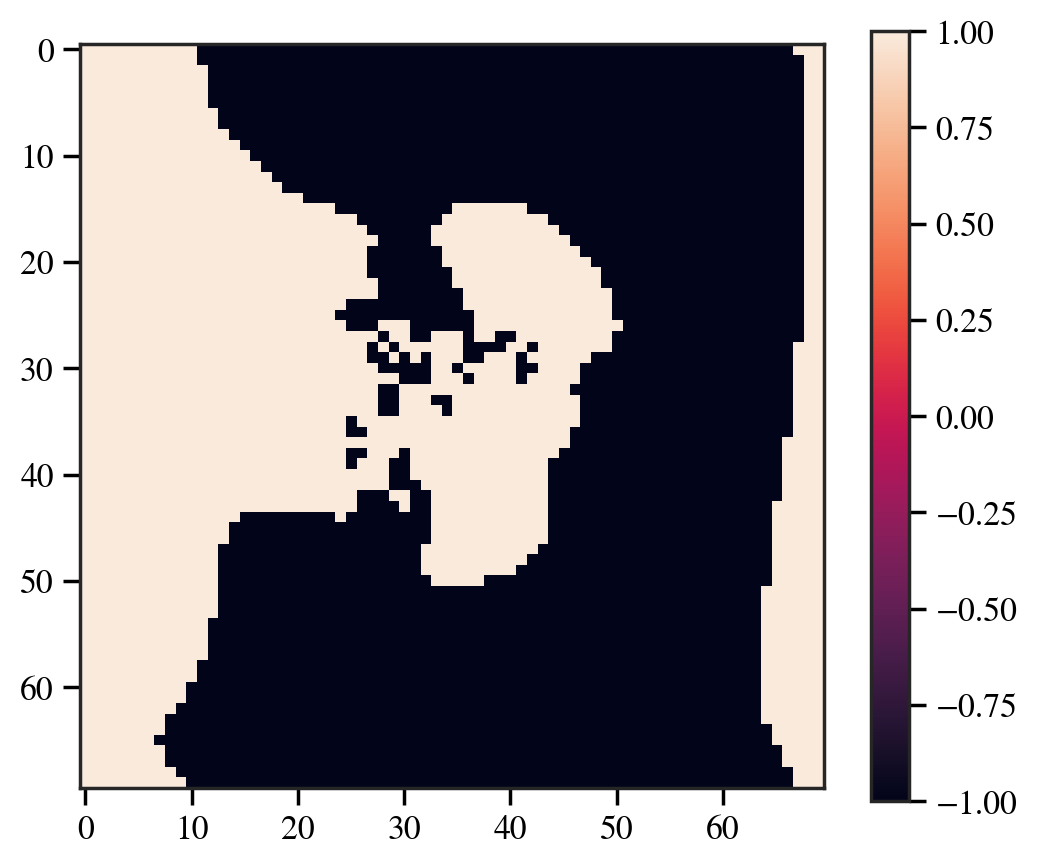

In [179]:
plt.imshow(np.sign(model.dotC.T))
plt.colorbar()

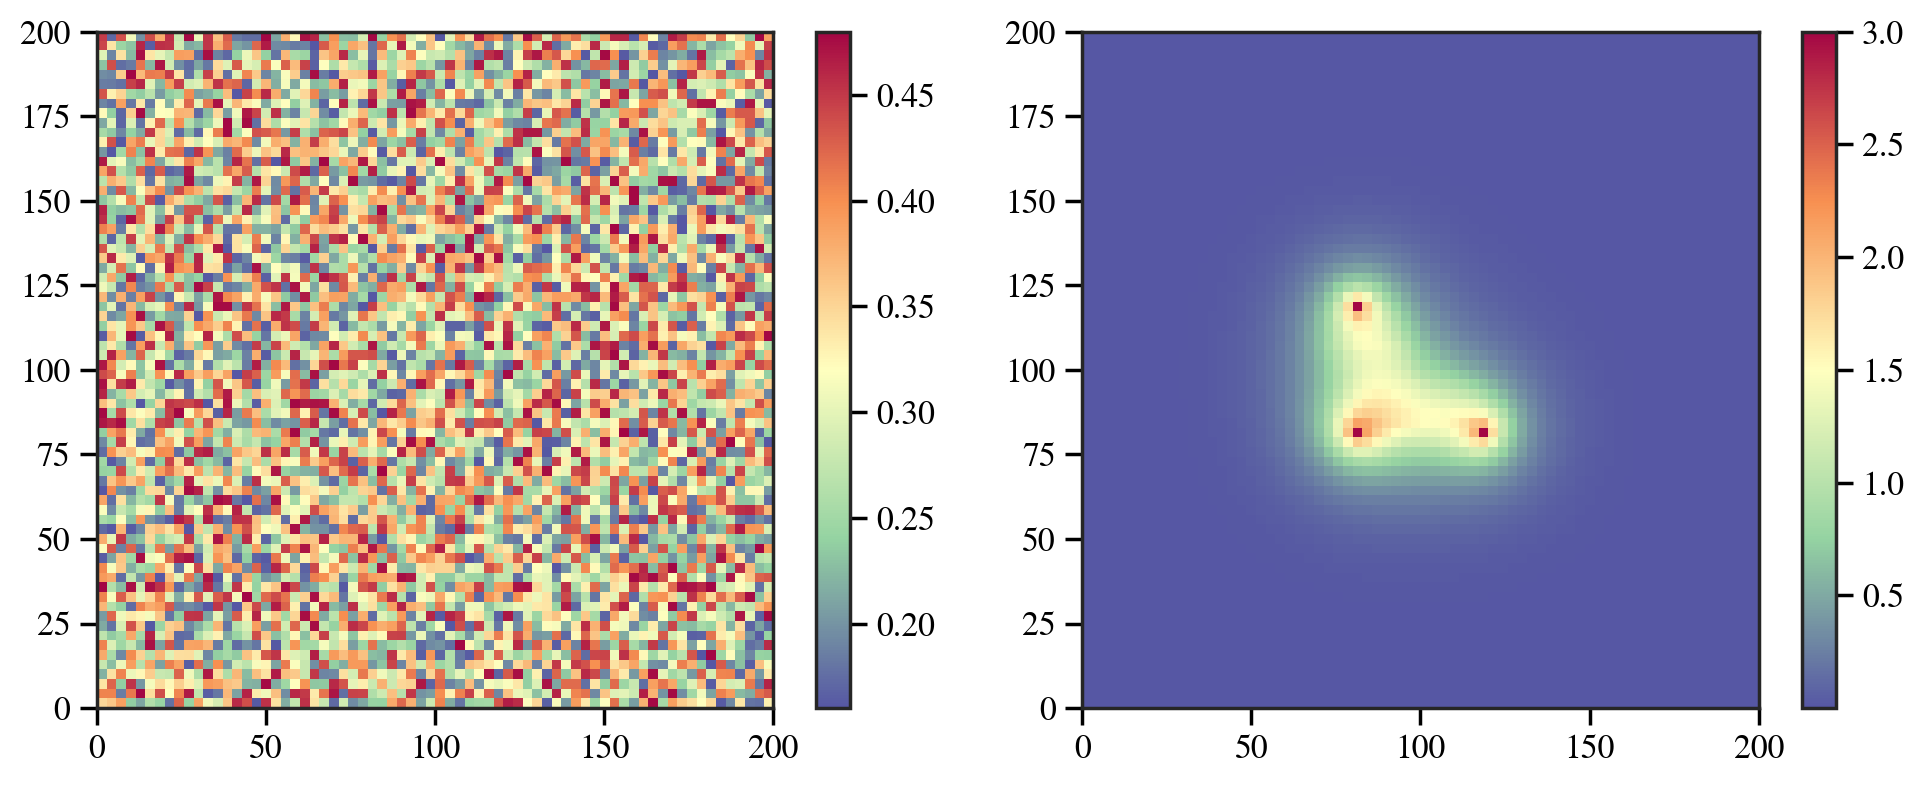

In [199]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]
pc1 = ax.imshow(model.u.T, cmap=cmap, extent=(0, self.boundaryLength, 0, self.boundaryLength), origin="lower")
plt.colorbar(pc1, ax=ax)
ax.set_xlim(0, self.boundaryLength)
ax.set_ylim(0, self.boundaryLength)
ax = axs[1]
pc2 = ax.imshow(model.c.T, cmap=cmap, extent=(0, self.boundaryLength, 0, self.boundaryLength), origin="lower")
plt.colorbar(pc2, ax=ax)
ax.set_xlim(0, self.boundaryLength)
ax.set_ylim(0, self.boundaryLength)
plt.tight_layout()

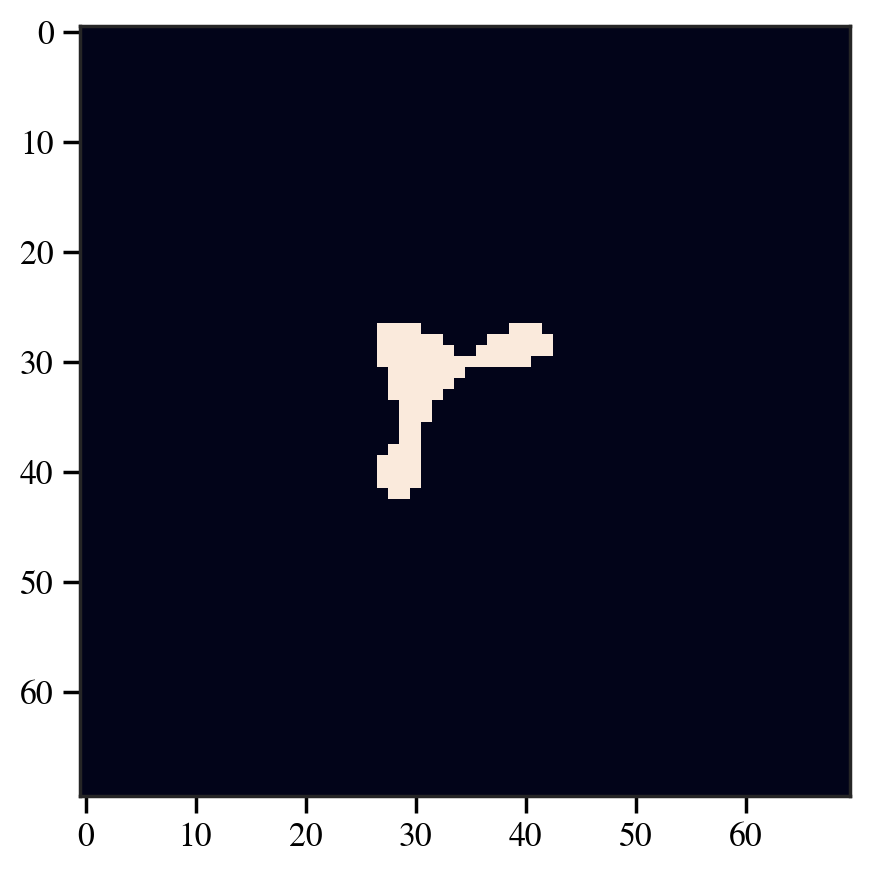

In [220]:
matrix = model.c.copy()
matrix = np.where(matrix > 1.4, 1, 0)
plt.imshow(matrix)

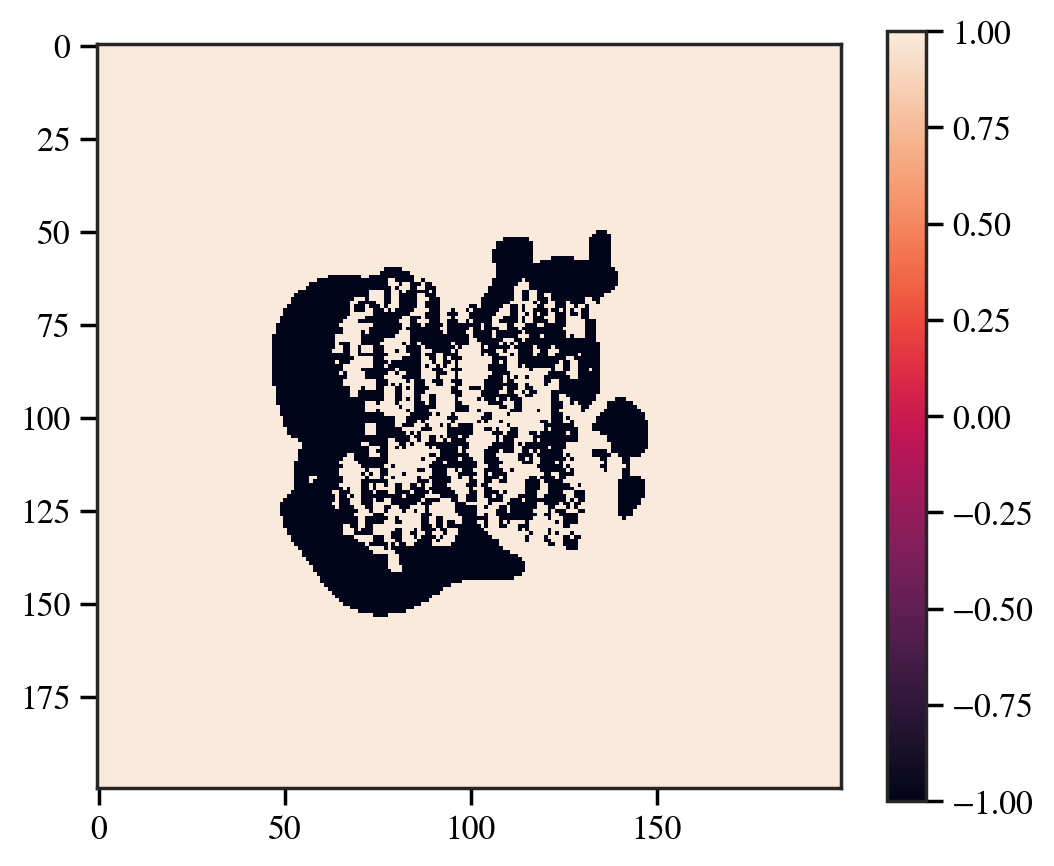

In [82]:
plt.imshow(np.sign(model.dotU))
# plt.imshow(model.dotU)
plt.colorbar()

  0%|          | 0/9 [00:00<?, ?it/s]

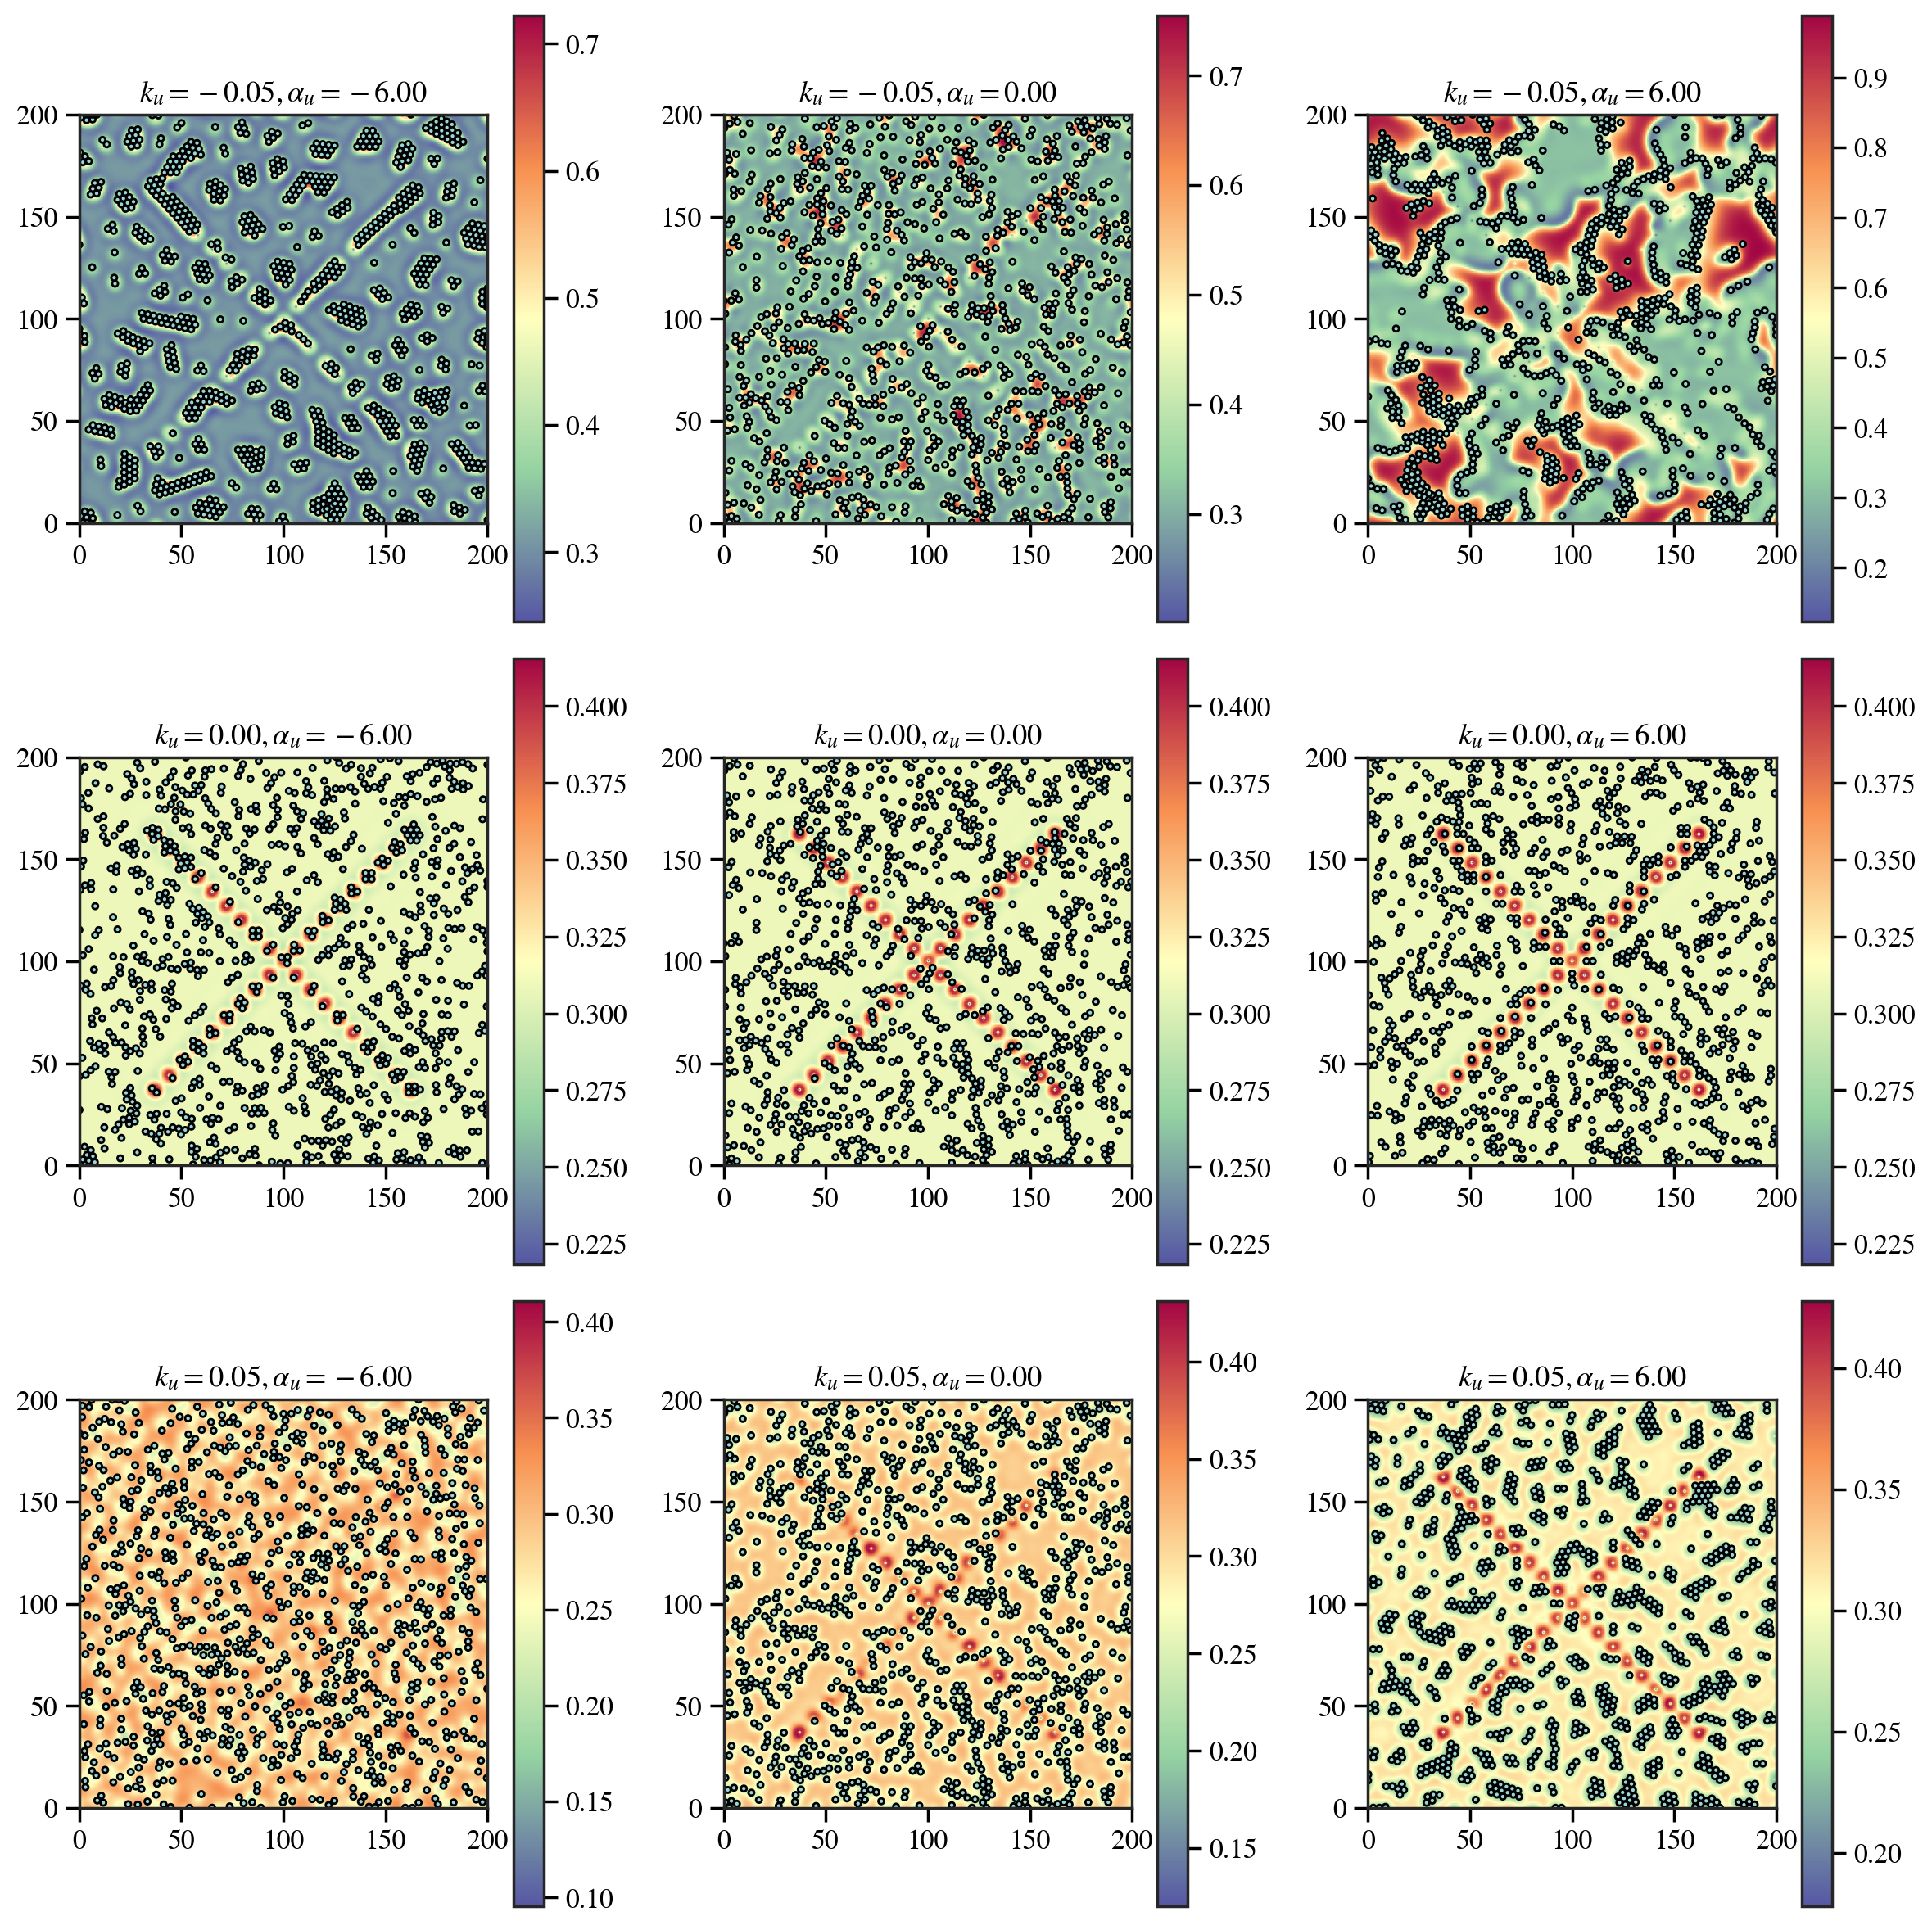

In [15]:
Aus = np.linspace(-6, 6, 3)
kus = np.linspace(-0.05, 0.05, 3)
productRateBetau = -0.1
productRateBetav = 0

SAVE_PATH = r"E:\MS_ExperimentData\general"

pathShift = 7
center = 100
nodePosition = [
    [
        [center - pathShift * i, center - pathShift * i],
        [center - pathShift * i, center + pathShift * i],
        [center + pathShift * i, center - pathShift * i],
        [center + pathShift * i, center + pathShift * i]
    ]
    for i in range(0, 10)
]
nodePosition = np.unique(np.concatenate(nodePosition, axis=0), axis=0)

fig = plt.figure(figsize=(len(Aus) * 4, len(kus) * 4))
idx = 1

for ku, Au in tqdm(product(kus, Aus), total=len(kus) * len(Aus)):
    model = PathPlanningGS(
        nodePosition=nodePosition,
        productRateBetau=productRateBetau, productRateBetav=productRateBetav,
        productRateKu=ku, productRateKv=0,
        u0=0.32, v0=0.25,
        decayRateKd=0.08, decayRateKf=0.03,
        diffusionRateDu=0.5, diffusionRateDv=0.25,
        chemoAlphaU=Au, chemoAlphaV=0,
        diameter=3, repelPower=2, repCutOff=True,
        boundaryLength=200, cellNumInLine=200,
        tqdm=True, dt=0.1, savePath=SAVE_PATH, overWrite=False
    )
    sa = StateAnalysis(model)
    ax = plt.subplot(len(kus), len(Aus), idx)
    idx += 1
    ax.set_title(rf"$k_u={ku:.2f}, \alpha_u={Au:.2f}$")
    sa.plot_spatial(ax=ax)

    im = ax.imshow(sa.totalU[-1].T, cmap=cmap)
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.savefig(f"./figs/Bu{productRateBetau}_Bv{productRateBetav}.png", dpi=200)